#### Information Theory

For a random variable X, we define the entropy (the average level of "information", "surprise", or "uncertainty") as follows:

For a discreet random variable:
$$
    Entropy(X) = - \sum_{x \in X} (P(X=x)*log_b(P(X=x)))
$$

For a continuous random variable
$$
    Entropy(X) = - \int_{-\infty}^{+\infty} (P(X=x)*log_b(P(X=x))) dx
$$

In [8]:
from dataclasses import dataclass

type Object  = dict[str, object]

@dataclass
class Node:
    tag: str
    children: dict[object, 'Node']

The ```tag``` varibale represents either the attribute name, for a non-leaf node or the class name for a leaf node. The ```children``` varibale represents the neighbours of the current node and can be ```None``` for leaf nodes and a list containing a pair for each possible value/range of values for the attriubute coresponding to the tag name

A Classifier is an object that can be trained on a list of already classified objcets and predict the class of new inputs

In [9]:
from abc import abstractmethod

class Classifier():
    def __init__(self, classification_attribute: str):
        self.classification_attribute = classification_attribute
        
    @abstractmethod
    def train(self, objects: list[Object]) -> None:
        pass
    
    @abstractmethod
    def fit(self, obj: Object) -> str:
        pass

#### Decision tree

In [10]:
from typing import Callable
import random

class DecisionTree(Classifier):
    def __init__(self, classification_attribute: str, choose_attribute: Callable[[list[Object], set[str]], str]):
        super().__init__(classification_attribute)
        self.choose_attribute = choose_attribute
        self.tree = None
        
    def train(self, objects: list[Object]) -> None:
        def build_tree(objects: list[Object], attributes: set[str]) -> Node:
            if all(obj[self.classification_attribute] == objects[0][self.classification_attribute] for obj in objects):
                return Node(objects[0][self.classification_attribute], {})
            if not attributes:
                return Node(max(set(obj[self.classification_attribute] for obj in objects), key=lambda x: sum(obj[self.classification_attribute] == x for obj in objects)), {})
                            
            attr = self.choose_attribute(objects, attributes)
            children = {}
            for value in set(obj[attr] for obj in objects):
                children[value] = build_tree([obj for obj in objects if obj[attr] == value], attributes - {attr})
            return Node(attr, children)
        
        attributes = set(objects[0].keys()) - {self.classification_attribute}
        self.tree = build_tree(objects, attributes)
        
    def fit(self, obj: Object) -> str:
        if self.tree is None:
            raise Exception("Classifier not trained")
        
        node = self.tree
        while node.children:
            if obj[node.tag] in node.children:
                node = node.children[obj[node.tag]]
            else:
                node = random.choice(list(node.children.values()))
        return node.tag

#### Information Gain Decision Tree

In [11]:
from collections import Counter
from math import log2

def subsets(objects: list[Object], attr: str) -> list[list[Object]]:
    values = set(obj[attr] for obj in objects)
    return [[obj for obj in objects if obj[attr] == value] for value in values]

def information_gain(objects: list[Object], attr: str, classification_attribute: str) -> float:
    def entropy(objects: list[Object]) -> float:
        n = len(objects)
        return -sum((count / n) * log2(count / n) for count in Counter(obj[classification_attribute] for obj in objects).values())
    
    return entropy(objects) - sum((len(subset) / len(objects)) * entropy(subset) for subset in subsets(objects, attr))

class IGDecisionTree(Classifier):
    def __init__(self, classification_attribute: str):
        super().__init__(classification_attribute)
        self.classifier = None
        
    def train(self, objects: list[Object]) -> None:
        choose_attribute = lambda objects, attributes: max(attributes, key=lambda attr: information_gain(objects, attr, self.classification_attribute))
        self.classifier = DecisionTree(self.classification_attribute, choose_attribute)
        self.classifier.train(objects)
        
    def fit(self, obj: Object) -> str:
        if self.classifier is None:
            raise Exception("Classifier not trained")
        
        return self.classifier.fit(obj)

#### Random Forest

In [12]:
from collections import Counter
import random

class RandomForest(Classifier):
    def __init__(self, classification_attribute: str, size: int = 10):
        super().__init__(classification_attribute)
        self.classifiers = []
        self.size = size
        
    def train(self, objects: list[Object]) -> None:
        self.classifiers = []
        choose_attribute = lambda _, attributes: random.choice(list(attributes))
        for _ in range(self.size):
            classifier = DecisionTree(self.classification_attribute, choose_attribute)
            classifier.train(objects)
            self.classifiers.append(classifier)
        
    def fit(self, obj: Object) -> str:
        if not self.classifiers:
            raise Exception("Classifier not trained")
        
        possible_classifications = [classifier.fit(obj) for classifier in self.classifiers]
        return Counter(possible_classifications).most_common(1)[0][0]

#### Accuracy test

Time to train for IGDecisiontree: 0.18556571006774902
Accuracy for IGDecisionTree: 0.878125


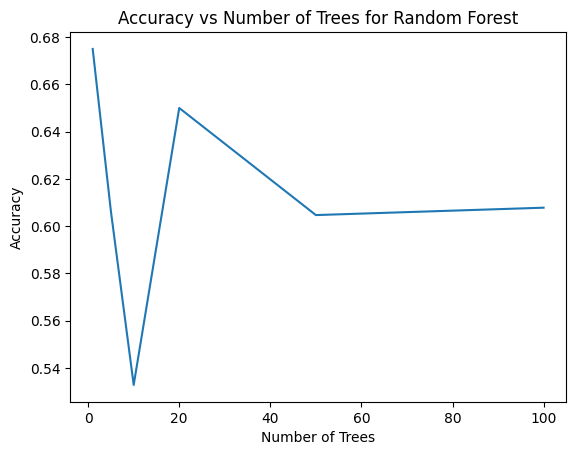

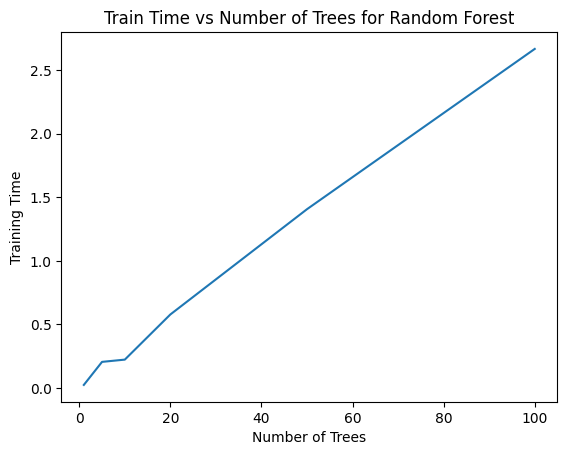

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from time import time

objects: list[Object] = pd.read_csv('./datasets/chess').to_dict('records')
train_objects: list[Object] = objects[:int(len(objects) * 0.8)]
test_objects:  list[Object] = objects[int(len(objects) * 0.8):]

classification_attribute = 'class'

ig_decision_tree = IGDecisionTree(classification_attribute)
t1 = time()
ig_decision_tree.train(train_objects)
t2 = time()
print(f"Time to train for IGDecisiontree: {t2 - t1}")

ig_decision_tree_accuracy = sum(ig_decision_tree.fit(obj) == obj[classification_attribute] for obj in test_objects) / len(test_objects)
print(f"Accuracy for IGDecisionTree: {ig_decision_tree_accuracy}")


trees_count = [1, 5, 10, 20, 50, 100]
random_forest_accuracies = []
random_forest_train_times = []
for count in trees_count:
    random_forest = RandomForest(classification_attribute, count)
    t1 = time()
    random_forest.train(train_objects)
    t2 = time()
    
    random_forest_accuracy = sum(random_forest.fit(obj) == obj[classification_attribute] for obj in test_objects) / len(test_objects)
    random_forest_accuracies.append(random_forest_accuracy)
    random_forest_train_times.append(t2 - t1)

plt.plot(trees_count, random_forest_accuracies)
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Trees for Random Forest')
plt.show()

plt.plot(trees_count, random_forest_train_times)
plt.xlabel('Number of Trees')
plt.ylabel('Training Time')
plt.title('Train Time vs Number of Trees for Random Forest')
plt.show()

#### Using SciKit

In [15]:
import pandas as pd
from sklearn.calibration import LabelEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

dataset = pd.read_csv('./datasets/chess')
X = dataset.drop('class', axis=1)
y = dataset['class']

for col in X.columns:
    labelEncoder = LabelEncoder()
    X[col] = labelEncoder.fit_transform(X[col])
y = LabelEncoder().fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf = DecisionTreeClassifier(criterion='entropy')

clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, predictions))


Accuracy: 1.0
